In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('taxi.xls')
df.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1


### 1 Общая информация

Предоставленный набор данных состоит из id предложений заказов водителям такси и их характеристики. Прогнозируемый показатель - ответ от водителя на предложение (принял/отклонил). На один заказ от клиента может приходиться несколько предложений водителям. Известнены день недели (каждому дню соответствует индекс 0-6) и час сделанного предложения, дата неизвестна (создать предикторы отвечающий за кол-во заказов (водителей) в определенном радиусе не получится). Но можно посчитать кол-во разосланых предложений на каждый заказ.<br><br>

Так же имеется:
* координата водителя на момент получения предложения;
* координата начала маршрута;
* протяжонность маршрута в км;
* продолжительность поездки в минутах;
* класс поезки (эконом, бизнес и т.д.);
* тип заказчика (физ.лицо, бизенс и т.д.)

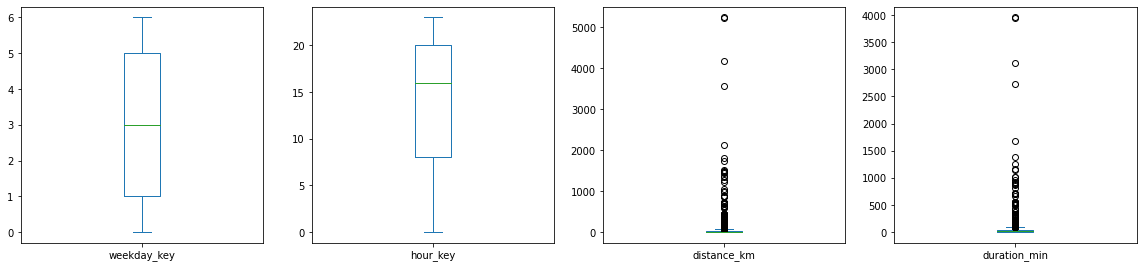

In [3]:
col_list = ['weekday_key', 'hour_key', 'distance_km', 'duration_min']
plt.figure(figsize=(20, 20))

for i, col_name in enumerate(col_list):
    plt.subplot(4, 4, 1 + i)
    df[col_name].plot.box();
plt.show();

distance_km и duration_min имеют некоторое количество выбросов. После обработки пропусков выбросы будут заменены quantile(0.99)

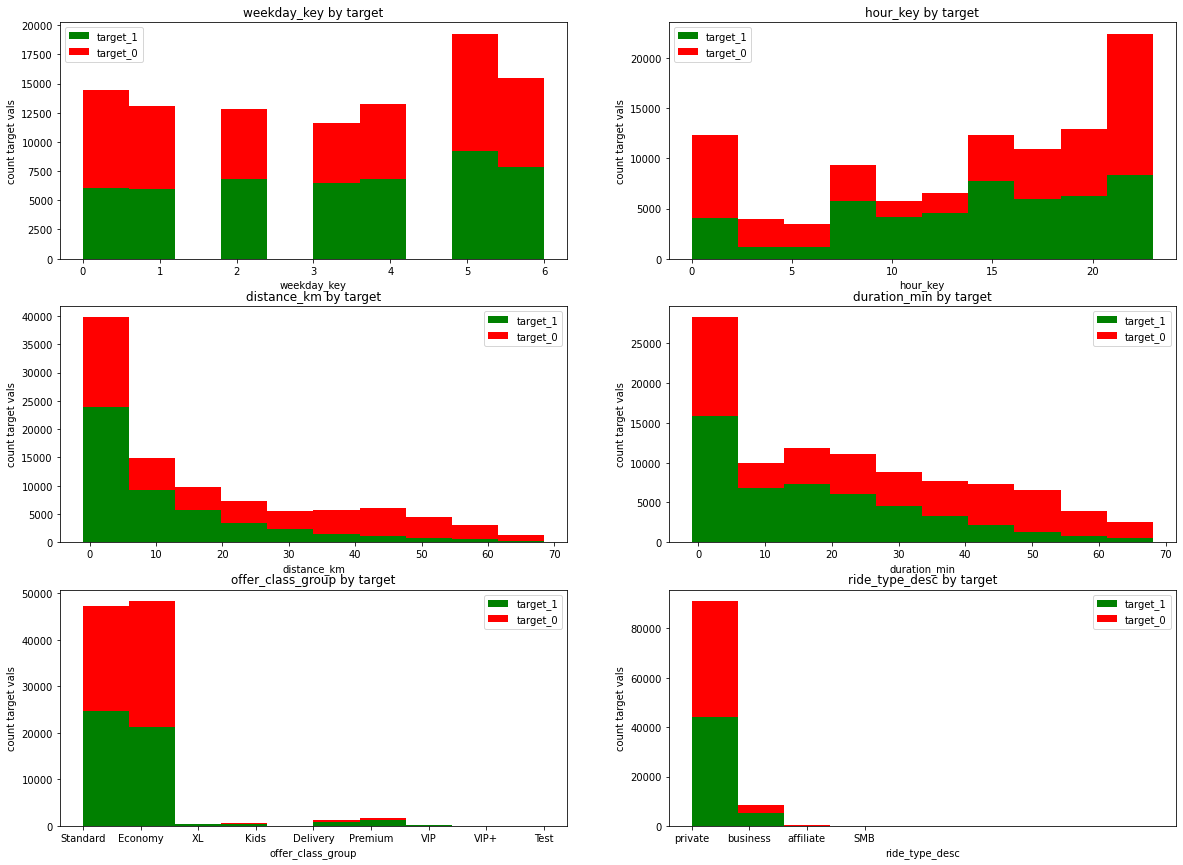

In [4]:
col_list = ['weekday_key', 'hour_key', 'distance_km', 'duration_min', 'offer_class_group', 'ride_type_desc']
plt.figure(figsize=(20, 20))

for i, col_name in enumerate(col_list):
    plt.subplot(4, 2, 1 + i)
    
    try:
        hist_range = (df[col_name].quantile(0.02), df[col_name].quantile(0.98))
    except:
        hist_range = (0, 8)
        
    plt.hist(x = [df[df['driver_response'] == 1][col_name], df[df['driver_response'] == 0][col_name]], 
             stacked = True, 
             color = ['g', 'r'],
             label = ['target_1', 'target_0'],
             range=hist_range
            )
    plt.title(f'{col_name} by target')
    plt.xlabel(col_name)
    plt.ylabel('count target vals')
    plt.legend()
plt.show();

### 2 Выявление пропусков

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   offer_gk                100000 non-null  int64  
 1   weekday_key             100000 non-null  int64  
 2   hour_key                100000 non-null  int64  
 3   driver_gk               100000 non-null  int64  
 4   order_gk                100000 non-null  int64  
 5   driver_latitude         100000 non-null  float64
 6   driver_longitude        100000 non-null  float64
 7   origin_order_latitude   100000 non-null  float64
 8   origin_order_longitude  100000 non-null  float64
 9   distance_km             100000 non-null  float64
 10  duration_min            100000 non-null  float64
 11  offer_class_group       100000 non-null  object 
 12  ride_type_desc          100000 non-null  object 
 13  driver_response         100000 non-null  int64  
dtypes: float64(6), int64(

Датафрэйм не содержит значения Nan. Требуется дополнительная проверка на недопустимые данные (в distance_km и duration_min замечены отрицательные значения)

In [6]:
def check_df(df):
    df_info = pd.DataFrame(columns=df.columns)
    
    bigger_than_zero_list = ['offer_gk', 'driver_gk', 'order_gk', 'driver_latitude', 'driver_longitude', 
                                'origin_order_latitude', 'origin_order_longitude', 'distance_km', 'duration_min']
    bigger_or_equal_zero_list = ['weekday_key', 'hour_key']

    stat = {}
    for i in bigger_than_zero_list:
        stat[i] = sum(df[i] <= 0)

    for i in bigger_or_equal_zero_list:
        stat[i] = sum(df[i] < 0)

    df_info = df_info.append(stat, ignore_index=True)
    
    return df_info

In [7]:
df_info = check_df(df)

In [8]:
# Кол-во пропусков
df_info

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,0.0,0.0,0.0,0.0,0.0,141.0,141.0,13.0,13.0,26359.0,26359.0,NaN,NaN,NaN


In [9]:
df['ride_type_desc'].value_counts()

private      91207
business      8533
affiliate      224
SMB             36
Name: ride_type_desc, dtype: int64

In [10]:
df['offer_class_group'].value_counts()

Economy     48335
Standard    47288
Premium      1773
Delivery     1290
Kids          588
XL            464
VIP           225
VIP+           29
Test            8
Name: offer_class_group, dtype: int64

In [11]:
# offer_class_group содержит категорию Test, возможно тестовые заказы которые следует удалить

In [12]:
df.driver_response.value_counts()

0    50752
1    49248
Name: driver_response, dtype: int64

In [13]:
# Классы принял/отклонил примерно равны

In [14]:
print(df[df['driver_latitude'] <= 0]['driver_response'].value_counts())
print(df[df['driver_longitude'] <= 0]['driver_response'].value_counts())
# Среди водителей, местоположение которых -1;-1, высокая доля принявших заказ
# скорее всего местоположение водителя и клиента совпадает

# пустые поля driver_latitude и driver_longitude будут заполнены соответствующими origin_order_latitude и origin_order_longitude

1    140
0      1
Name: driver_response, dtype: int64
1    140
0      1
Name: driver_response, dtype: int64


In [15]:
df[df['origin_order_latitude'] < 0]

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
1687,760201,6,17,1479,217451,55.730637,37.491326,-1.0,-1.0,2.942,6.300,Economy,private,1
9407,729617,1,21,1835,404650,55.484133,37.850971,-1.0,-1.0,-1.000,-1.000,Standard,private,0
43328,1033378,3,10,5586,386108,55.762383,37.772572,-1.0,-1.0,14.127,21.433,Economy,private,1
43688,299807,3,18,14,69484,55.640164,37.534014,-1.0,-1.0,9.998,22.133,Standard,private,1
51365,833482,0,20,75,782429,55.619920,37.395172,-1.0,-1.0,28.607,32.967,Economy,private,0
56004,1009826,3,19,4185,247078,55.758792,37.749308,-1.0,-1.0,11.281,21.167,Economy,private,1
58769,212838,2,7,6304,542162,55.638462,37.335678,-1.0,-1.0,48.557,47.300,Economy,private,0
60245,753313,1,16,1168,583148,55.984804,37.159184,-1.0,-1.0,-1.000,-1.000,Economy,private,1
64117,936069,5,15,737,139197,55.753351,37.667157,-1.0,-1.0,2.252,7.400,Standard,private,1
64694,1095202,3,20,5669,659570,55.741113,37.618121,-1.0,-1.0,7.199,20.200,Premium,private,1


In [16]:
# distance_km и duration_min имеют по 26359 пропусков, нужно проверить совпадают ли они
# по 152 значения имеют нулевые значения, но будут обрабатываться так же как и -1

df['dd_both_na'] = df.apply(func = lambda x : 1 if x['distance_km'] <= 0 and x['duration_min'] <= 0 else 0, axis=1)

In [17]:
sum(df['dd_both_na'])
# Пропуски совпадают

26359

In [18]:
del df['dd_both_na']

In [19]:
print(df[df['distance_km'] <= 0]['driver_response'].value_counts())
# Соотношение классов для наблюдений с пустым расстоянием и продолжительностью поездки: 55% на 45%
# Пропуски будут заполнены средними значениями

1    14508
0    11851
Name: driver_response, dtype: int64


In [20]:
def fill_driver_na_location(x):
    """!!! Не забыть !!!
        Переделать else: df криво передается
    """
    if x['origin_order_latitude'] > 0 or x['origin_order_longitude'] > 0:
        x['driver_latitude'] = x['origin_order_latitude']
        x['driver_longitude'] = x['origin_order_longitude']
    else:
        x['driver_latitude'] = df['driver_latitude'].mean()
        x['driver_longitude'] = df['driver_longitude'].mean()
        
    return x


def fill_client_na_location(x):
    """!!! Не забыть !!!
        Переделать else: df криво передается
        
        
        Пустые поля origin_order_latitude и origin_order_longitude заполняются 
        соответствующими driver_latitude и driver_longitude
    """
    if x['driver_latitude'] > 0 or x['driver_longitude'] > 0:
        x['origin_order_latitude'] = x['driver_latitude']
        x['origin_order_longitude'] = x['driver_longitude']
    else:
        x['origin_order_latitude'] = df['origin_order_latitude'].mean()
        x['origin_order_longitude'] = df['origin_order_longitude'].mean()
        
    return x


In [21]:
df = df.apply(func = lambda x : fill_driver_na_location(x) if x['driver_latitude'] <= 0 else x, axis=1)
df = df.apply(func = lambda x : fill_client_na_location(x) if x['origin_order_latitude'] <= 0 else x, axis=1)

In [22]:
# замена значений меньше или равных 0 на np.nan, для удобства обработки через метод fillna()
df['distance_km'] = df['distance_km'].apply(lambda x : np.nan if x <= 0 else x)
df['duration_min'] = df['duration_min'].apply(lambda x : np.nan if x <= 0 else x)

# обработка выбросов

qdistance = df['distance_km'].quantile(0.99)
qduration = df['distance_km'].quantile(0.99)

df['distance_km'] = df['distance_km'].apply(lambda x : qdistance if x > qdistance else x)
df['duration_min'] = df['duration_min'].apply(lambda x : qduration if x > qduration else x)

# заполнение пропусков
df['distance_km'].fillna(df['distance_km'].mean(), inplace = True)
df['duration_min'].fillna(df['duration_min'].mean(), inplace = True)

In [23]:
# повторная проверка
check_df(df)

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


### 3 Оценить и описать зависимость переменных между собой

offer_gk, driver_gk, order_gk - айдишники предложения, водителя и заказа, их можно исключить из рассмотрения

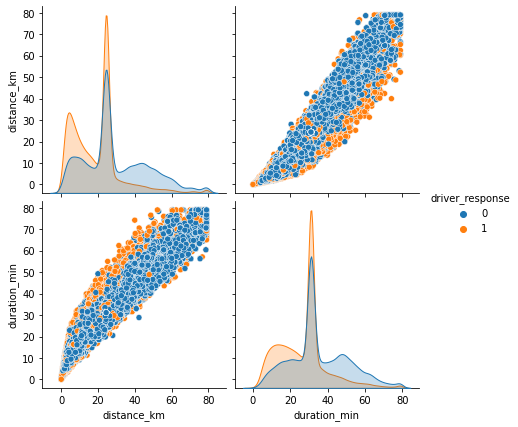

In [24]:
cols = ['distance_km', 'duration_min','driver_response']
sns_plot = sns.pairplot(df[cols], hue='driver_response', height=3)

# Довольно очевидная прямопропорциональная связь расстояния и продолжительности поездки
# Пики в распределении distance_km и duration_min - заполненные пропуски средними

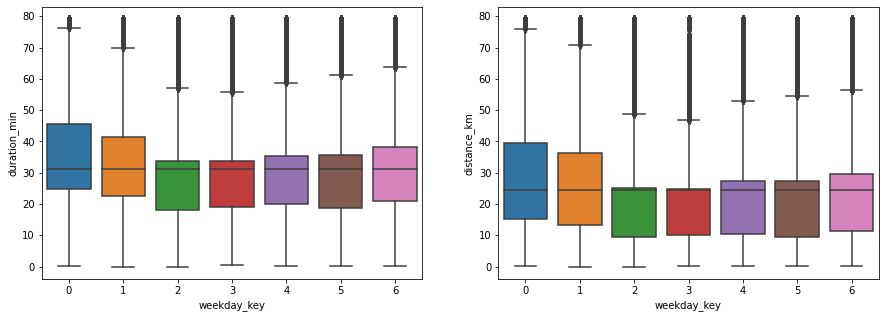

In [25]:
fig, axs = plt.subplots(1,2, figsize = (15, 5))

sns.boxplot(x="weekday_key", y="duration_min", data=df[['weekday_key', 'duration_min']], ax=axs[0])
sns.boxplot(x="weekday_key", y="distance_km", data=df[['weekday_key', 'distance_km']], ax=axs[1]);

# Расстояние и продолжительность поездки в зависимости от дня недели

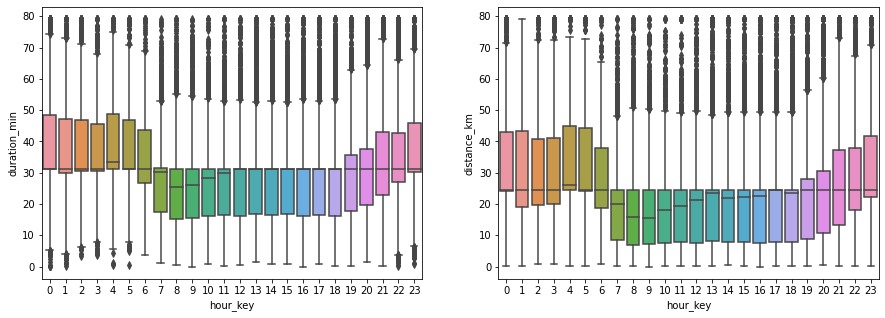

In [26]:
fig, axs = plt.subplots(1,2, figsize = (15, 5))

sns.boxplot(x="hour_key", y="duration_min", data=df[['hour_key', 'duration_min']], ax=axs[0])
sns.boxplot(x="hour_key", y="distance_km", data=df[['hour_key', 'distance_km']], ax=axs[1]);

# Расстояние и продолжительность поездки в зависимости от времени суток

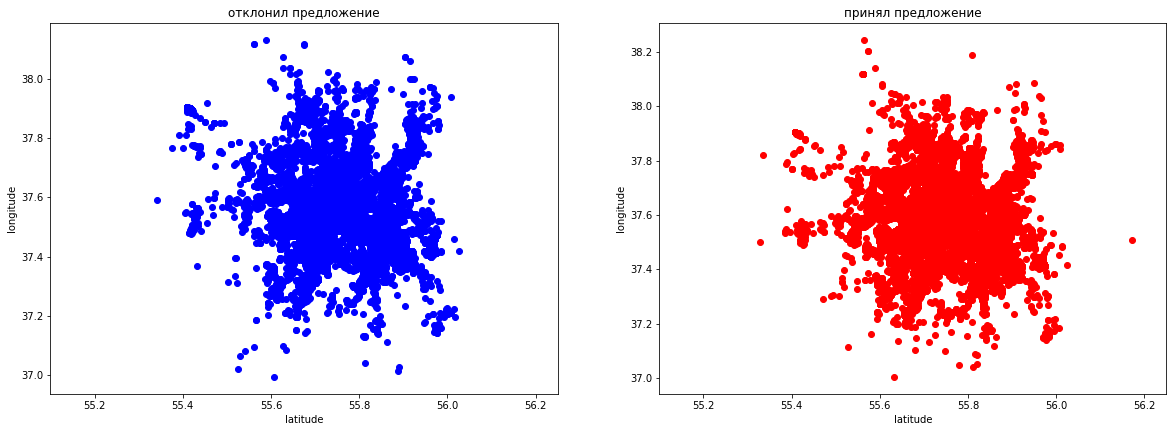

In [27]:
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.xlim(55.1, 56.25)
plt.plot(df['origin_order_latitude'][df.driver_response == 0], 
         df['origin_order_longitude'][df.driver_response == 0], 'o', color='blue')
plt.title('отклонил предложение')
plt.xlabel('latitude')
plt.ylabel('longitude')

plt.subplot(2, 2, 2)
plt.xlim(55.1, 56.25)
plt.plot(df['origin_order_latitude'][df.driver_response == 1], 
         df['origin_order_longitude'][df.driver_response == 1], 'o', color='red')
plt.title('принял предложение')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show();

# Распределение предложений по местоположению схоже для обоих классов

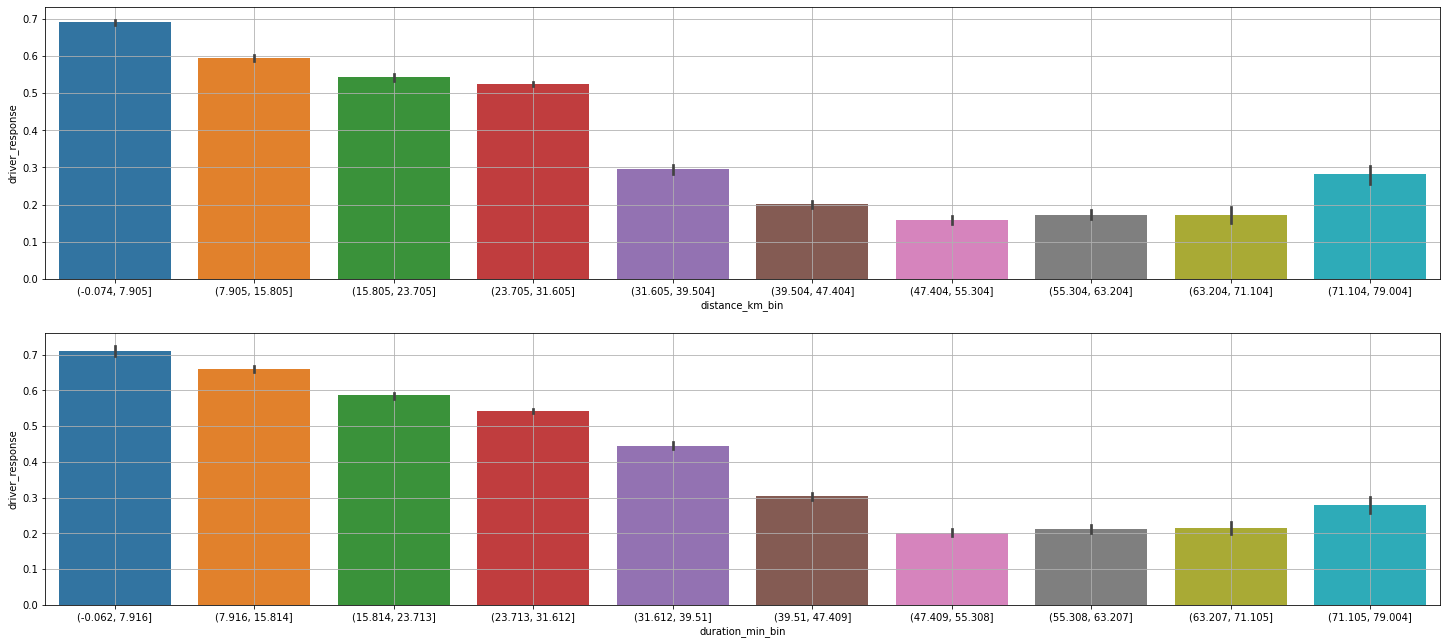

In [28]:
fig = plt.figure(figsize=(25, 11))

for i, col_name in enumerate(['distance_km', 'duration_min']): 
    new_col_name = col_name + '_bin'
    df[new_col_name] = pd.cut(df[col_name], 10)


    ax = fig.add_subplot(2, 1, 1 + i)
    g = sns.barplot(x = new_col_name, y = 'driver_response', data=df, ax = ax)
    ax.grid(True)
plt.show();


# Влияние расстояния и продолжительности поездки на ответ водителя
# оба показателя обратнопропорциональны ответу водителя

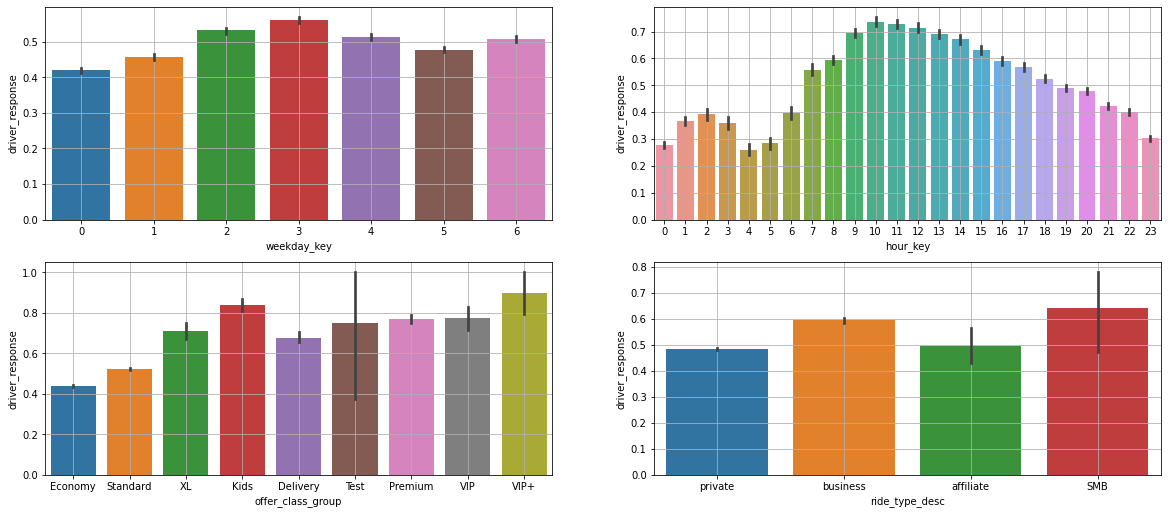

In [29]:
col_list = ['weekday_key', 'hour_key', 'offer_class_group', 'ride_type_desc']
fig = plt.figure(figsize=(20, 18))

for i, col_name in enumerate(col_list):
    ax = fig.add_subplot(4, 2, 1 + i)
    g = sns.barplot(x = col_name, y = 'driver_response', data=df, ax = ax)
    ax.grid(True)
plt.show();


# В некоторые дни вероятность положительного ответа может быть несколько выше
# В середине дня вероятность положительного ответа выше, что может быть связано с снижением спроса на такси
# Некоторые категории имеют повышенную верояность п. ответа (можно их объеденить по вероятности)
# Тип поездки оказывает некоторое влияние на вероятность п.ответа; тип "SMB" имеет высокий доверительный интервал

### 4	Определите стратегию преобразования категориальных признаков для дальнейшего построения моделей.

Перечень категориальных переменных:
* weekday_key
* hour_key
* offer_class_group
* ride_type_desc
<br><br>
Значения данных полей будут заменены на долю положительных откликов для соответствующего класса

In [30]:
class CustomCatTransformer():
    def __init__(self):
        self.columns = ['weekday_key', 'hour_key', 'offer_class_group', 'ride_type_desc']
        
    
    def fit(self, X, y):
        dataframe = pd.concat([X, pd.DataFrame(y)], axis=1)
        
        category_features_encoder = {}
        
        for feature in dataframe[self.columns]:
            category_features_encoder[feature] = {}
            
            categories = list(X[feature].unique())
            for cat in categories:
                slice_ = dataframe[dataframe[feature] == cat]['driver_response']
                
                category_features_encoder[feature][cat] = sum(slice_.values) / len(slice_)           
            
        self.category_features_encoder = category_features_encoder
        
        return self
    
    
    def transform(self, X):
        self.X = X.copy()
        
        for col in self.columns:
            self.X.loc[:,col] = X.loc[:,col].apply(lambda x : self.category_features_encoder[col][x])
        return self.X
            

### 5 Найти признаки, которые можно разделить на другие, или преобразовать в другой тип данных. Удалить лишние, при необходимости

1) Из признаков местоположения составим расстояние от водителя до клиента. Координаты в модели использоваться не будут;<br>
2) Добавим признак количества предложений на один закаказ;<br>
3) Из полей duration_min и distance_km оставим один;<br>
4) После вышеприведенных преобразований поля driver_gk и order_gk будут исключены<br>

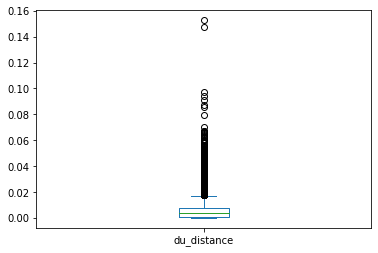

In [31]:
df['du_distance'] = (((df['driver_latitude'] - df['origin_order_latitude']) ** 2) + ((df['driver_longitude'] - df['driver_longitude']) ** 2)) ** 0.5
df['du_distance'].plot.box();

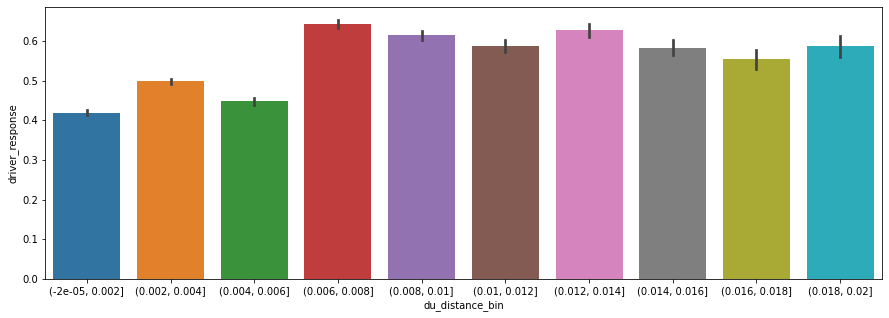

In [32]:
# исключаем выбросы на этапе визуализации
new_df = df[df['du_distance'] < 0.02].copy()

fig = plt.figure(figsize=(15, 5))

new_df['du_distance_bin'] = pd.cut(new_df['du_distance'], 10)
g = sns.barplot(x = 'du_distance_bin', y = 'driver_response', data=new_df)
ax.grid(True)
plt.show();

In [33]:
# du_distance не будет включен в будущую модель 
del df['du_distance']

In [34]:
# кол-во предложений на один заказ

df_order = df[['offer_gk', 'order_gk']].groupby(by='order_gk').count()

df['offers_count'] = df.apply(func = lambda x : df_order.loc[x['order_gk']], axis=1)

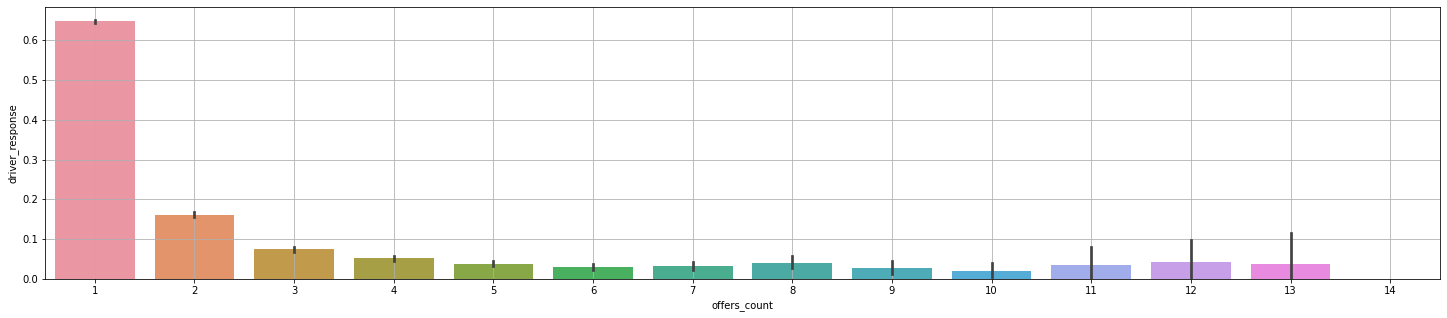

In [35]:
fig = plt.figure(figsize=(25, 11))

ax = fig.add_subplot(2, 1, 1)
g = sns.barplot(x = 'offers_count', y = 'driver_response', data=df, ax = ax)
ax.grid(True)
plt.show();

In [36]:
# Новый параметр имеет визуально заметную зависимость с вероятностью принятия 
# предложения (один заказ не может быть принят несколькоми водителями)

In [37]:
# из distance_km и duration_min оставим только duration_min, поскольку он более полно характеризует затраты на
# дорогу до клиента

### Разделить выборку на обучаемую и тестовую

In [38]:
df.head()

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response,distance_km_bin,duration_min_bin,offers_count
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,24.420884,31.130926,Economy,private,0,"(23.705, 31.605]","(23.713, 31.612]",2
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802000,25.217000,Standard,private,1,"(15.805, 23.705]","(23.713, 31.612]",1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747000,9.800000,Economy,private,0,"(-0.074, 7.905]","(7.916, 15.814]",1
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,24.420884,31.130926,Economy,private,1,"(23.705, 31.605]","(23.713, 31.612]",1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383000,19.250000,Economy,private,1,"(7.905, 15.805]","(15.814, 23.713]",1


In [39]:
features = ['weekday_key', 'hour_key', 'duration_min', 'offer_class_group', 'ride_type_desc', 'offers_count']

X, y = df[features], df['driver_response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Обучить несколько моделей, выбрать критерий оценки выбрать наилучшую

In [40]:
for model in [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]:

    pipe = Pipeline([
        ('cat', CustomCatTransformer()),
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    
    #костыли ради classification_report
    _step1 = pipe[0].transform(X_test)
    _step2 = pipe[1].transform(_step1)
    
    print(type(pipe[2]).__name__, "\n")
    print(classification_report(pipe[2].predict(_step2), y_test))
    print("\n" + "-" * 60 + "\n")
    
    

LogisticRegression 

              precision    recall  f1-score   support

           0       0.60      0.82      0.70     12315
           1       0.87      0.68      0.76     20685

    accuracy                           0.73     33000
   macro avg       0.73      0.75      0.73     33000
weighted avg       0.77      0.73      0.74     33000


------------------------------------------------------------

DecisionTreeClassifier 

              precision    recall  f1-score   support

           0       0.67      0.69      0.68     16286
           1       0.69      0.67      0.68     16714

    accuracy                           0.68     33000
   macro avg       0.68      0.68      0.68     33000
weighted avg       0.68      0.68      0.68     33000


------------------------------------------------------------

RandomForestClassifier 

              precision    recall  f1-score   support

           0       0.66      0.71      0.69     15634
           1       0.72      0.67      0

Поскольку бизнес задача не сформулирована и не установлени приоритет между precision и recall, оценим качество модели по f1-score:
* LogisticRegression - 0.73
* DecisionTreeClassifier - 0.68
* RandomForestClassifier - 0.69
<br></br>
#### Логистическая регрессия по выбранному показателю является наилучшей

### Проверим распределение верных/ложных предсказаний в зависимости от местоположения

In [41]:
post_df = pd.concat([X_test, pd.DataFrame(y_test)], axis=1)

post_df = post_df.join(df[['origin_order_latitude', 'origin_order_longitude']], how='inner')

In [42]:
pipe = Pipeline([
        ('cat', CustomCatTransformer()),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ])
    
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

In [43]:
post_df['driver_response_pred'] = y_pred
post_df['is_error'] = post_df.apply(func = lambda x : 1 if x['driver_response_pred'] != x['driver_response'] else 0, axis=1)

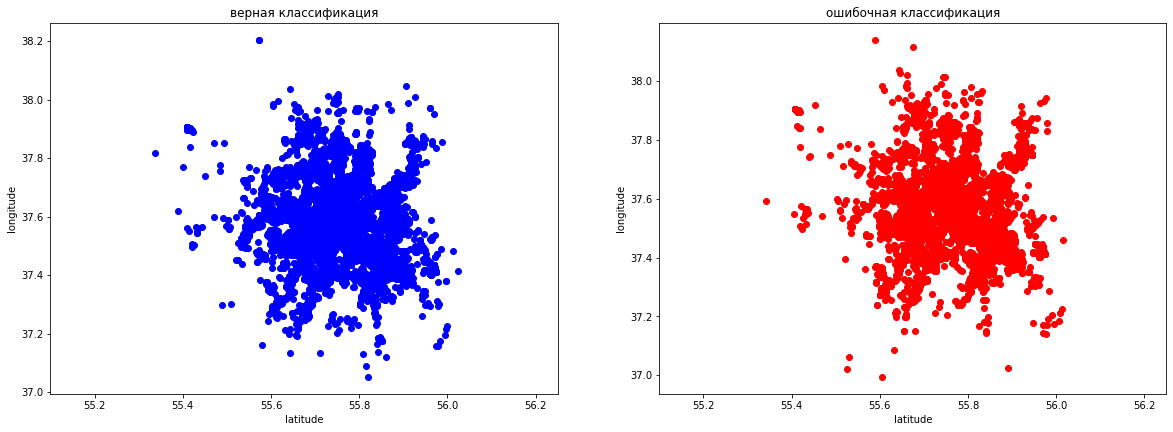

In [44]:
plt.figure(figsize=(20, 15))

plt.subplot(2, 2, 1)
plt.xlim(55.1, 56.25)
plt.plot(post_df['origin_order_latitude'][post_df.is_error == 0], 
         post_df['origin_order_longitude'][post_df.is_error == 0], 'o', color='blue')
plt.title('верная классификация')
plt.xlabel('latitude')
plt.ylabel('longitude')

plt.subplot(2, 2, 2)
plt.xlim(55.1, 56.25)
plt.plot(post_df['origin_order_latitude'][post_df.is_error == 1], 
         post_df['origin_order_longitude'][post_df.is_error == 1], 'o', color='red')
plt.title('ошибочная классификация')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show();

# Распределение предложений по местоположению схоже для обоих классов

In [45]:
# Распределение верных/ложных предсказаний не зависит от местоположения